## Importing libraries

In [12]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
import random

## Setting seed

In [13]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [14]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [16]:
X_train, y_train = load_dataset('../ShanghaiTech/part_B/train_data/images/', '../ShanghaiTech/part_B/train_data/ground-truth/')

In [17]:
X_test, y_test = load_dataset('../ShanghaiTech/part_B/test_data/images/', '../ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [18]:
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Zamroź warstwy

# base_model.trainable = True
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [19]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 18325.6055 - mae: 101.5075 - val_loss: 8997.6006 - val_mae: 75.5983
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 959ms/step - loss: 8784.6777 - mae: 75.2350 - val_loss: 7863.2739 - val_mae: 66.1505
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 957ms/step - loss: 7990.9609 - mae: 65.7813 - val_loss: 7408.7510 - val_mae: 58.6618
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 977ms/step - loss: 7139.9199 - mae: 60.6868 - val_loss: 6658.3384 - val_mae: 58.2705
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 993ms/step - loss: 6448.5312 - mae: 59.7324 - val_loss: 6259.0859 - val_mae: 54.1215
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 971ms/step - loss: 5905.4136 - mae: 54.5595 - val_loss: 5964.4155 - val_mae: 51.4133
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 968ms/step - loss: 5790.9814 - mae: 54.8452 - val_loss: 5773.7344 - val_mae: 48.6266
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 959ms/step - loss: 5535.0811 - mae: 51.7336 - val_loss: 5560.5469 - va

## Training curves visualisation

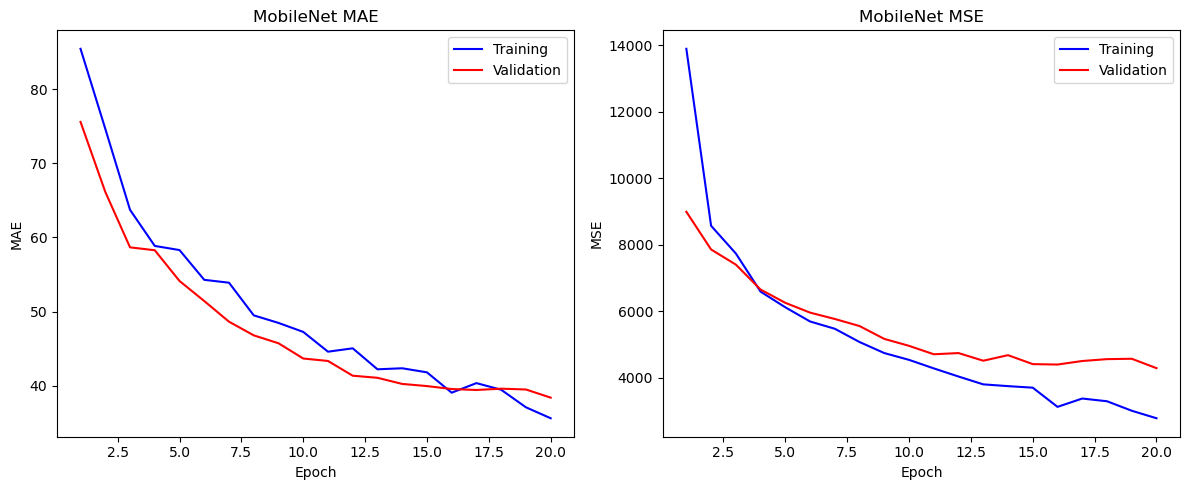

In [20]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('MobileNet MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('MobileNet MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


## Making predictions

In [21]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 524ms/step


In [22]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 20.  23.]
 [193. 181.]
 [172. 157.]
 [ 43.  37.]
 [ 98.  70.]
 [ 69.  57.]
 [ 35.  44.]
 [189. 227.]
 [157. 165.]
 [209. 476.]
 [106. 139.]
 [203. 316.]
 [156. 164.]
 [131. 110.]
 [ 38.  20.]
 [187. 131.]
 [ 53.  48.]
 [143. 183.]
 [136. 101.]
 [178. 204.]
 [ 35.  40.]
 [114. 143.]
 [197. 146.]
 [190. 513.]
 [ 37.  70.]
 [ 83. 175.]
 [ 23.  51.]
 [ 56.  55.]
 [ 93.  67.]
 [ 57.  72.]
 [ 27.  56.]
 [148. 165.]
 [ 24.  32.]
 [145. 149.]
 [ 45.  48.]
 [110.  80.]
 [ 97. 117.]
 [ 69. 162.]
 [170. 137.]
 [117. 120.]
 [ 82.  72.]
 [143. 122.]
 [165. 198.]
 [114. 133.]
 [102. 147.]
 [ 35.  29.]
 [ 39.  70.]
 [ 20.  35.]
 [ 49.  24.]
 [167. 251.]
 [ 41.  59.]
 [141.  67.]
 [ 42.  61.]
 [192. 248.]
 [225. 252.]
 [192. 147.]
 [ 33.  57.]
 [124. 121.]
 [ 61.  47.]
 [228. 505.]
 [167. 297.]
 [180. 465.]
 [122. 167.]
 [ 34.  43.]
 [ 41.  46.]
 [120.  91.]
 [176. 263.]
 [108.  92.]
 [ 71. 117.]
 [ 44.  48.]
 [ 65.  54.]
 [ 83.  73.]
 [ 98. 122.]
 [ 88.  60.]
 [229. 170.]
 [110. 167.]
 [ 37.  57.]

## Metrics

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.5255749225616455
MSE: 4293.6171875
MAE: 38.35126495361328
RMSE: 65.52569580078125
